# Preparing fMRIprep data for connectivity analysis

This tutorial will use the same dataset and analysis as the GUI tutorial, so they can be seen as complimentary.  
If you have already downloaded the data, you can skip the following steps and simply modify the path to the `BIDSLayout` if necessary.

To get the data, `datalad` and `git-annex` are required: https://www.datalad.org/.  
You can install them by running the following commands in any terminal (ideally one where your Comet Python environment is activated):

```bash
pip install datalad-installer
datalad-installer git-annex -m datalad/packages
pip install datalad
```

You can then install the dataset in the current working directory and download a single BOLD + confounds file by typing:

```bash
datalad install https://github.com/OpenNeuroDatasets/ds004489.git
cd ds004489
datalad get derivatives/sub-114/ses-1/func/sub-114_ses-1_task-catLoc_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
datalad get derivatives/sub-114/ses-1/func/sub-114_ses-1_task-catLoc_run-1_desc-confounds_timeseries.tsv
```

Once this is completed, we start by initializing the dataset with pybids (make sure the dataset is in the same folder as the tutorial file or adjust the path):

In [1]:
import bids

dataset = bids.BIDSLayout("ds004489", derivatives=True)
dataset

BIDS Layout: ...ories/comet/tutorials/ds004489 | Subjects: 15 | Sessions: 31 | Runs: 113

We can then query the dataset. Please note that while we can see all files (we installed the entire dataset), we downloaded only a single BOLD and confounds file for the actual use, and all other files are empty placeholders.

For example, we could get all preprocessed BOLD files from sub-114 in the MNI152NLin2009cAsym space as follows:

In [ ]:
bold_files = dataset.get(
    subject="114",
    suffix="bold",
    desc="preproc",
    space="MNI152NLin2009cAsym",
    extension=".nii.gz",
    return_type="filename")

bold_files

As we only downloaded a single BOLD and confounds file, we have to narrow the query down:

In [ ]:
available_files = dataset.get(
    subject="114",
    session="1",
    task="catLoc",
    run="1",
    scope="derivatives",
    space=["MNI152NLin2009cAsym", None],
    suffix=["bold", "timeseries"],
    extension=[".nii.gz", ".tsv"],
    return_type="filename"
)
available_files

We can then proceed perform cleaning and parcellation with `nilearn`:

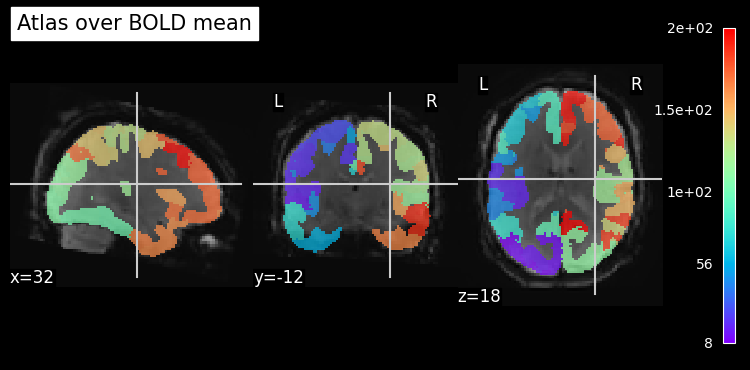

Cleaned and parcellated time series has shape: (275, 200)


/tmp/ipykernel_91490/1909134578.py:25: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_file, confounds=confounds)


In [4]:
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn import datasets, maskers, plotting, image

confounds = available_files[0]
bold_file = available_files[1]

# Use nilearn to pick a denoising strategy
confounds, _ = load_confounds_strategy(bold_file, denoise_strategy="simple")

# Get paths to Schaefer atlas
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2, verbose=0)
atlas_img = schaefer.maps
labels = schaefer.labels

# Plot atlas over mean BOLD image to see if things match up
mean_bold = image.mean_img(bold_file, copy_header=True)
plotting.plot_roi(atlas_img, bg_img=mean_bold, title="Atlas over BOLD mean", cmap='rainbow')
plotting.show()

# Set up the masker
masker = maskers.NiftiLabelsMasker(labels_img=atlas_img, standardize="zscore_sample", detrend=True,
                                   t_r=2.0, low_pass=0.1, high_pass=0.01)

# Perform cleaning + parcellation
time_series = masker.fit_transform(bold_file, confounds=confounds)
print("Cleaned and parcellated time series has shape:", time_series.shape)

And finally estimate dFC:

/home/mibur/miniconda3/envs/comet-test/lib/python3.13/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


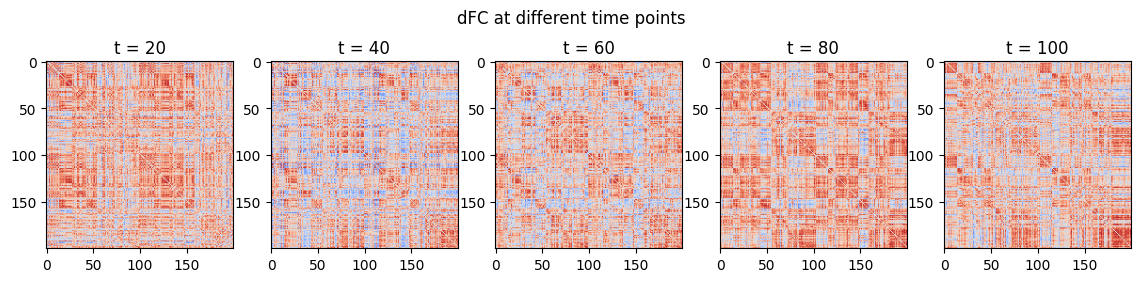

In [5]:
from comet import connectivity
from matplotlib import pyplot as plt

sw = connectivity.SlidingWindow(time_series)
dfc = sw.estimate()

# Plot
fig, ax = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle("dFC at different time points")
for i in range(5):
    ax[i].imshow(dfc[:,:,(1+i)*20], cmap="coolwarm", vmin=-1, vmax=1)
    ax[i].set_title(f"t = {(1+i)*20}")